<B>Preface</B><BR>
Natural language is a large data source common in data science.  One way machines can construct meaning is by looking at which words are co-located.  This assignment is based on the SAT solver assignment described here: http://nifty.stanford.edu/2017/guerzhoy-SAT-synonyms/2015/p3_synonyms.pdf  I STRONGLY recommend you read the entire lab as linked to in the previous link.  This assignment is a chance for you to hone your Natural Language Processing(NLP) skills This assignment is also an opportunity to practice your data analytics skills.  
<P>
<B>Part 1: Cosine similarity and semantic descriptors.   </B><BR>
Complete Part 1, a-c as outlined in the lab.  You need to write a function to calculate cosine similarity as well as one to build semantic descriptors from sentences and another to build semantic descriptors from files.  
<p>
 


In [ ]:
#------------------------------------------------------------------------------#
# This code was written for lab 3 of CST 475,          © Justin Boehnen 2022             
# taught at Oregon Tech by Prof. Cecily Heiner
#------------------------------------------------------------------------------#
from os import dup2
import functools
from scipy import spatial
from math import floor
import numpy as np
import re
from google.colab import drive
import time
import pprint

def prepare_similarity_vectors(vec1, vec2):
  vec1_words = []
  vec1_vals = []
  vec2_words = []
  vec2_vals = []
  
  for word in vec1:
    vec1_words.append(word)
    vec2_words.append(word)

  for word in vec2:
    vec2_words.append(word)
    vec1_words.append(word)
  
  vec1_words = list(set(vec1_words))
  vec1_words.sort()
  vec2_words = list(set(vec2_words))
  vec2_words.sort()

  for i, word in enumerate(vec1_words):
    if word in vec1:
      vec1_vals.append(vec1[word])
    else:
      vec1_vals.append(0)

  for i, word in enumerate(vec2_words):
    if word in vec2:
      vec2_vals.append(vec2[word])
    else:
      vec2_vals.append(0)

  return [vec1_vals, vec2_vals]

def cosine_similarity(vec1, vec2):
  vectors = prepare_similarity_vectors(vec1, vec2)
  return spatial.distance.cosine(vectors[0], vectors[1])

def negative_distance_similarity(vec1, vec2):
  vectors = prepare_similarity_vectors(vec1, vec2)
  return spatial.distance.euclidean(vectors[0], vectors[1])

def normalized_negative_distance_similarity(vec1, vec2):
  vectors = prepare_similarity_vectors(vec1, vec2)
  norm_vec1 = vectors[0]/np.linalg.norm(vectors[0])
  norm_vec2 = vectors[1]/np.linalg.norm(vectors[1])
  return spatial.distance.euclidean(norm_vec1, norm_vec2)

def build_semantic_descriptors(sentences):
  # make list of all unique keys
  all_keys = []
  for line in sentences:
    for word in line:
      all_keys.append(word)
  all_keys = list(set(all_keys))

  # for each keyₙ make a list of all other words in sentences with keyₙ
  key_val_list = []
  for i, key in enumerate(all_keys):
    key_val_list.append([])
    for line in sentences:
      if key in line:
        for word in line:
          if word != key:
            key_val_list[i].append(word)

  # now for every word associated with keyₙ (the lists made in the previous step)
  # count the number of times that words appears in sentences with keyₙ
  # from that information build a dictionary such that keyₙ has a corresponding
  # dictionaryₙ where every key and value in dictionaryₙ is a word and number 
  # (respectively) representing the number of times that word appears in 
  # sentences with keyₙ
  semantic_dict = dict()
  for i, key in enumerate(all_keys):
    per_word_dict = dict();
    for word in key_val_list[i]:
      if word in per_word_dict.keys():
        per_word_dict[word] = per_word_dict[word] + 1
      else:
        per_word_dict.update({word: 1})
    semantic_dict.update({key: per_word_dict})

  return semantic_dict

def merge_two_semantic_descriptors(d1, d2):
  new_dict = d1.copy()

  for key in d2.keys():
    if key in d1.keys():
      for subkey in d2[key].keys():
        if subkey in d1[key].keys():
          new_dict[key].update({subkey: d1[key][subkey] + d2[key][subkey]})
        else:
          new_dict[key].update({subkey: d2[key][subkey]})
    else:
      new_dict.update({key: d2[key]})

  return new_dict

def build_semantic_descriptors_from_files(filenames, percent = 100):
  start = time.time()
  #drive.mount('/content/gdrive', force_remount=True)
  conjoined_dict = dict()
  for filename in filenames:
    file = open("/content/gdrive/My Drive/Colab Notebooks/{}".format(filename))
    contents = (file.read()).lower()
    if(percent != 100):
      contents = contents[0:int(floor(len(contents)*percent/100))]
    file.close()
    sentences = re.split("\.|\!|\?", contents)
    sem_input = []
    for sentence in sentences:
      words = re.split("\s|\,|\-|\:|\;|\"|\\ufeff", sentence) # |\'
      while '' in words:
        words.remove('')
      sem_input.append(words)
    sem_dict = build_semantic_descriptors(sem_input)
    conjoined_dict = merge_two_semantic_descriptors(conjoined_dict, sem_dict)
  
  end = time.time()
  print(f"{'Semantic desriptor complete, time elapsed: '} {str(round(end-start,2)) + ' seconds' if end-start < 60 else str(round((end-start)/60,2)) + ' minutes'} {' total keys: ' + str(len(conjoined_dict.keys()))}")
  return conjoined_dict

def most_similar_word(word, choices, semantic_descriptors, similarity_fn):
  highest_similarity = np.Infinity;
  index_of_highest_similarity = 0;
  for i, choice in enumerate(choices):
    similarity = similarity_fn(semantic_descriptors[word], semantic_descriptors[choice])
    if similarity < highest_similarity: # closest to 0
      highest_similarity = similarity
      index_of_highest_similarity = i

  return choices[index_of_highest_similarity]

def run_similarity_test(filename, semantic_descriptors, similarity_fn, pre_built_descriptors = {}):
  #drive.mount('/content/gdrive', force_remount=True)
  num_correct = 0
  testfile = open("/content/gdrive/My Drive/Colab Notebooks/{}".format(filename))
  testlines = testfile.readlines()
  testfile.close()
  #drive.flush_and_unmount()
  semantic_dict = {}
  if(pre_built_descriptors == {}):
    semantic_dict = build_semantic_descriptors_from_files(semantic_descriptors)
  else:
    semantic_dict = pre_built_descriptors
  num_questions = len(testlines)
  questions = []
  correct_answers = []
  options = []
  for line in testlines:
    words = line.split()
    questions.append(words[0])            # question is index 0
    correct_answers.append(words[1])      # answer is index 1
    options.append(words[2:len(words)])  # options are ind 2 and up

  for i, question in enumerate(questions):
    if question in semantic_dict.keys() and options[i][0] in semantic_dict.keys() and options[i][1] in semantic_dict.keys():
      answer = most_similar_word(question, options[i], semantic_dict, similarity_fn)
    else:
      answer = "NONE"
      continue
    if (answer == correct_answers[i]):
      num_correct = num_correct + 1
    #print(f"{'Question ' + str(i):<12} {'answered: ' +answer:<24} {'correct: ' + ('(yes) ' if answer == correct_answers[i] else '(no)  ') + correct_answers[i]}")

  if(num_questions == 0): 
    return 1  

  return num_correct/num_questions

def the_trial_of_the_gods(filename, semantic_descriptors, percent = 100):

  sem_desc = build_semantic_descriptors_from_files(semantic_descriptors, percent)

  # test 1: cosine
  start = time.time()
  score = run_similarity_test(filename, semantic_descriptors, cosine_similarity, sem_desc)
  end = time.time()
  print("TEST 1: COSINE                       | SCORE: {}% accurate! | TIME: {}ms".format(str(round(score*100,3)),round((end-start)*1000,2)))

  # test 2: negative dist
  #start = time.time()
  #score = run_similarity_test(filename, semantic_descriptors, negative_distance_similarity, sem_desc)
  #end = time.time()
  #print("TEST 2: NEGATIVE DISTANCE            | SCORE: {}% accurate! | TIME: {}ms".format(str(round(score*100,3)),round((end-start)*1000,2)))

  # test 3: norm negative dist
  #start = time.time()
  #score = run_similarity_test(filename, semantic_descriptors, normalized_negative_distance_similarity, sem_desc)
  #end = time.time()
  #print("TEST 3: NORMALIZED NEGATIVE DISTANCE | SCORE: {}% accurate! | TIME: {}ms".format(str(round(score*100,3)),round((end-start)*1000,2)))

########################## TESTING STUFF ###########################
drive.mount('/content/gdrive', force_remount=True)

testences = [['i','am','a','sick','man'],
             ['i','am','a','spiteful','man'],
             ['i','am','an','unattractive','man'],
             ['i','believe','my','liver','is','diseased'],
             ['however','i','know','nothing','at','all', 'about','my',
              'disease','and','do','not','know','for','certain',
              'what','ails','me',]]

choices = ['i','am','a','sick','man','spiteful','unattractive',
           'believe','my','liver','is','diseased','however',
           'know','nothing','at','all','about','my','disease','and',
           'do','not','know','for','certain','what','ails','me']

files = ["Swanns_Way.txt", "War_and_Peace.txt"]

#print(build_semantic_descriptors(testences))
#build_semantic_descriptors_from_files(files, 10)
#d1 = {'the':{'quick':1, 'brown':1, 'fox':1}, 'quick': {'the':1, 'brown':1, 'fox':1}, 'brown': {'the':1, 'quick':1, 'fox':1}, 'fox':{'the':1,'quick':1,'brown':1}}
#d2 = {'the':{'fox':1, 'jumped':1, 'over':1}, 'fox': {'the':1, 'jumped':1, 'over':1}, 'jumped': {'the':1, 'fox':1, 'over':1}, 'over':{'the':1,'fox':1,'jumped':1}}
#print(merge_two_semantic_descriptors(d1,d2))
#the_trial_of_the_gods("test.txt", files)

the_trial_of_the_gods("test.txt", files)


drive.flush_and_unmount()

Mounted at /content/gdrive
Semantic desriptor complete, time elapsed:  6.34 minutes  total keys: 24260
TEST 1: COSINE                       | SCORE: 65.0% accurate! | TIME: 143.48ms


# Graphs (part 2C):

### Time VS Percent:
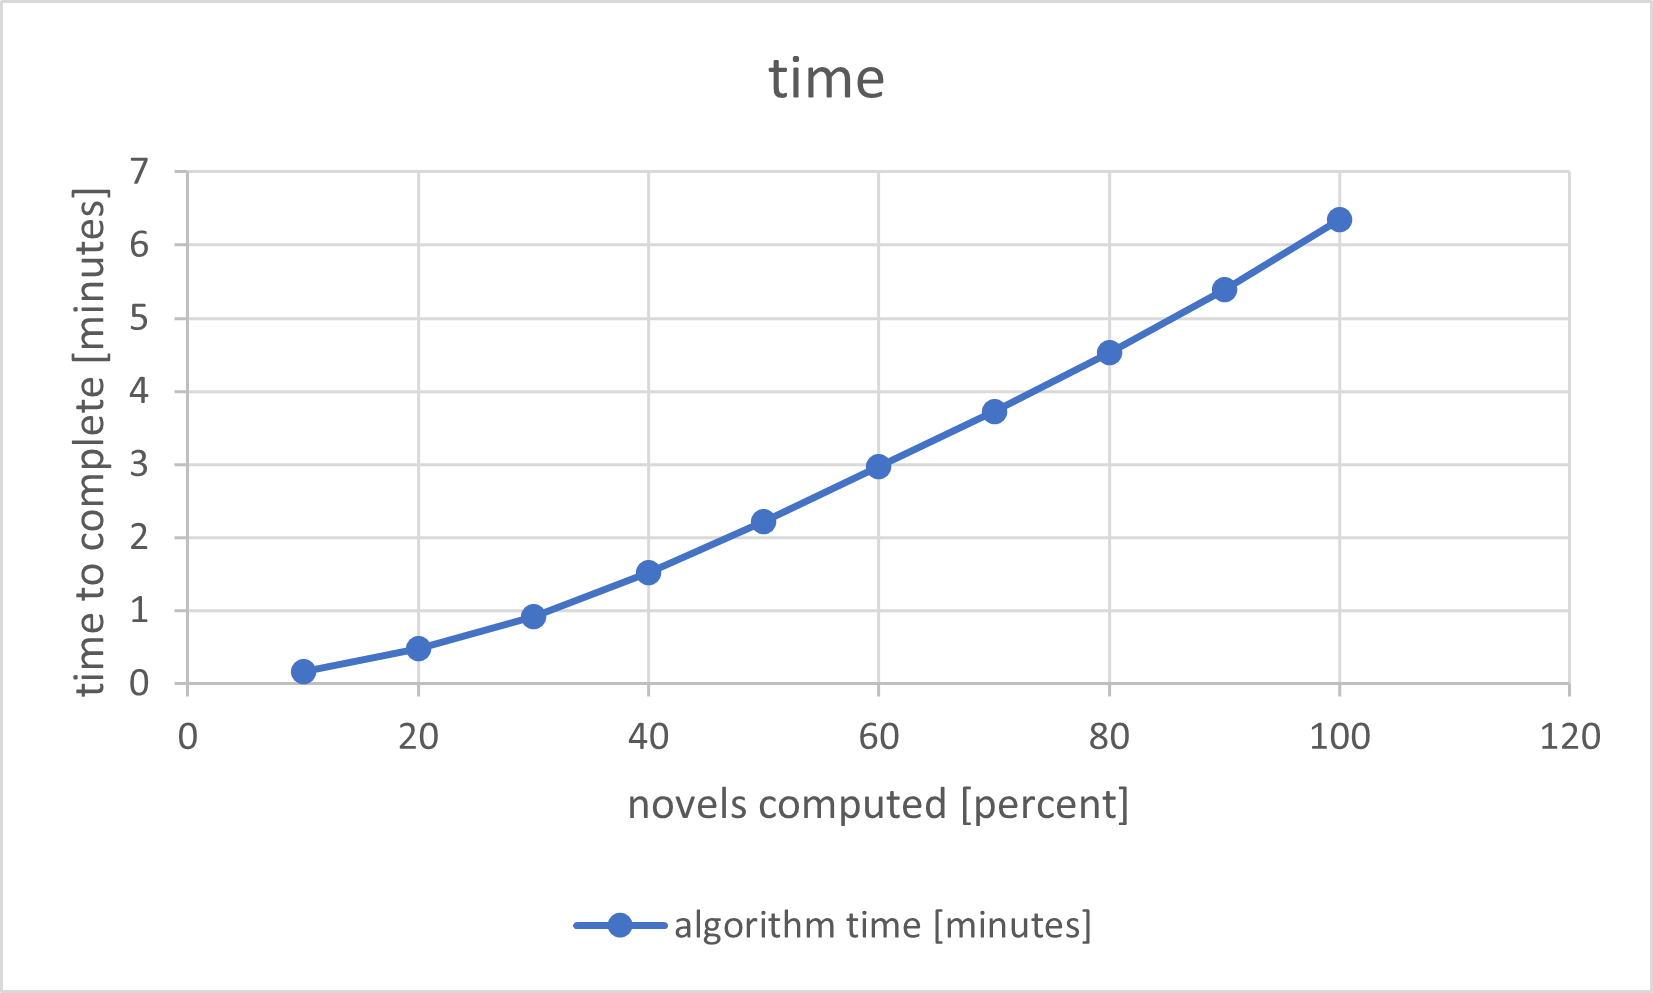
### Accuracy VS Percent:
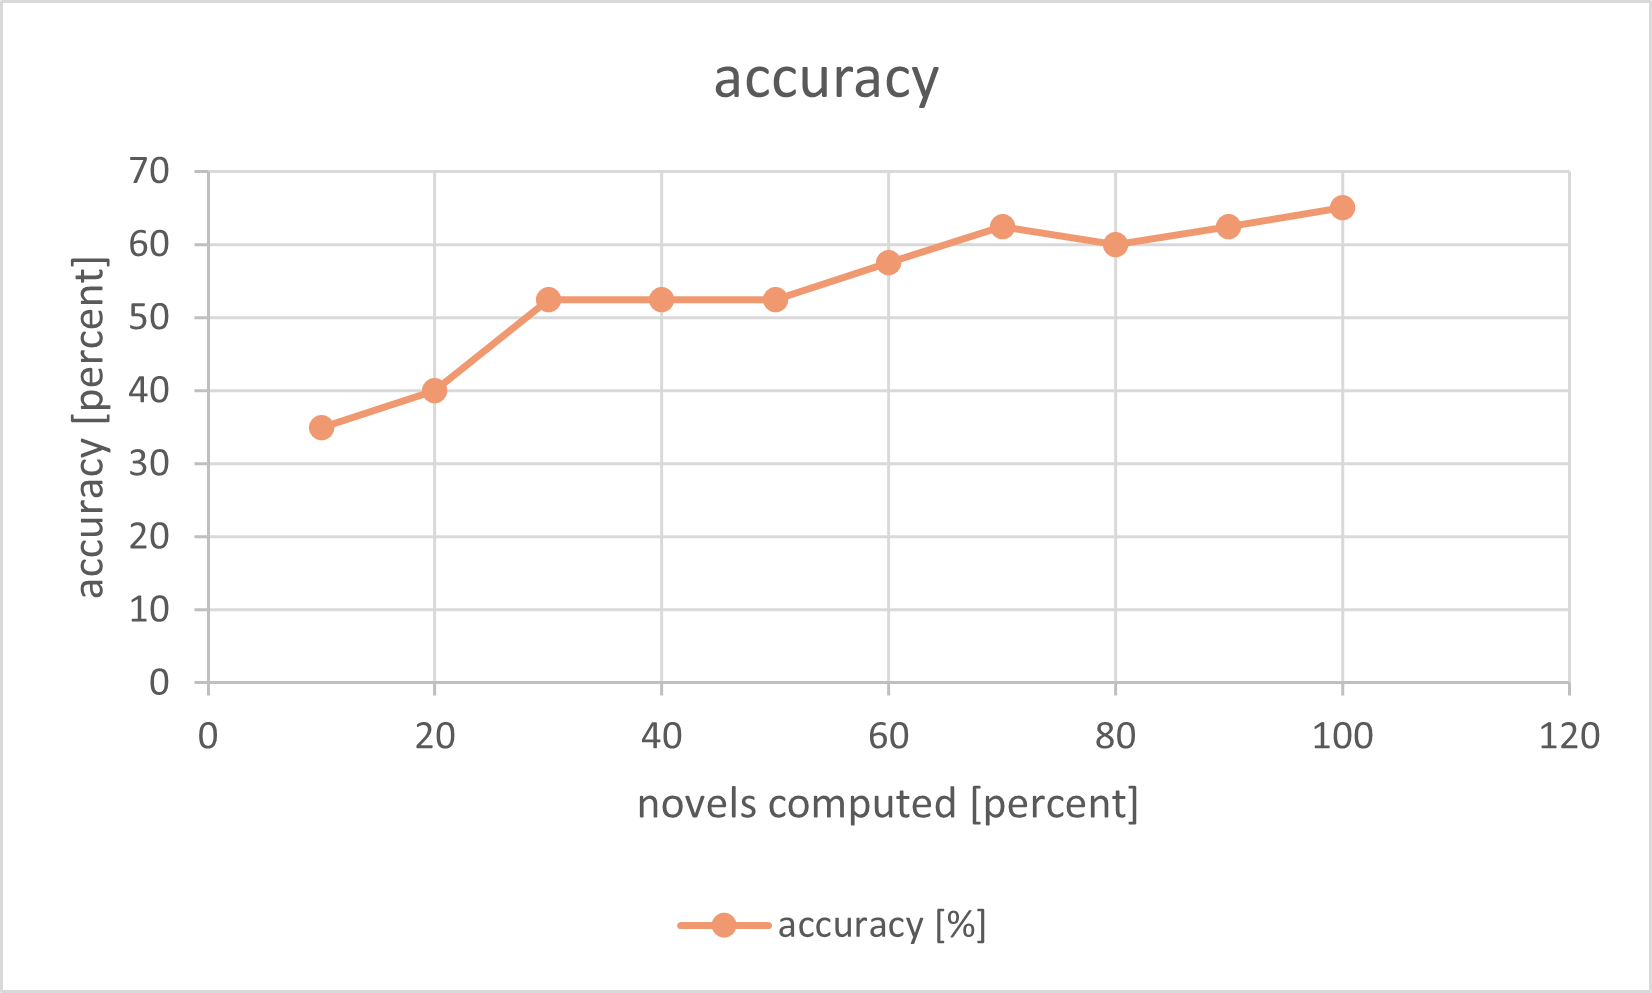
### Raw Data:
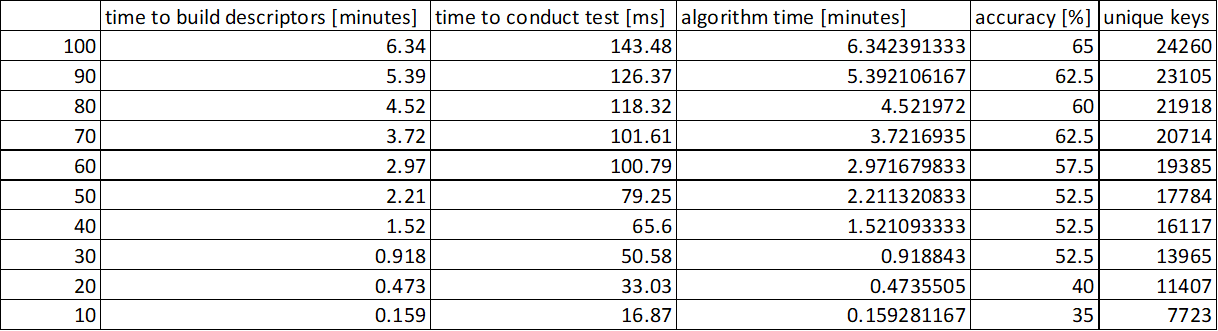

 <B>Part 2: Most similar word, taking a practice SAT test</B><BR>
Complete Part 1, d-e as outlined in the lab.  You do NOT need to worry about part f.  

 <B>Part 3: Lab Task Requests</B><BR>
Complete Part 2 as outlined in the lab.  Note that there are 3 parts.  